In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.preprocessing.image import ImageDataGenerator

2023-06-21 11:40:24.144252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt

In [3]:
import shutil

In [4]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

In [5]:
import cv2

In [344]:
import fast_ml

In [346]:
from fast_ml.model_development import train_valid_test_split

In [6]:
images = np.load('/Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/data/interim/images.npy')

In [7]:
df = pd.read_csv('/Users/chinmayasukumar/Documents/Springboard/Capstone 3 - Metal defect detection/data/interim/data.csv')

In [8]:
df = pd.get_dummies(df, columns=['Type'])

In [9]:
df.head()

,Filename,Number,Type_Crazing,Type_Inclusions,Type_Patches,Type_Pitted,Type_Rolled,Type_Scratches
0,Cr_1.bmp,1,1,0,0,0,0,0
1,Cr_10.bmp,10,1,0,0,0,0,0
2,Cr_100.bmp,100,1,0,0,0,0,0
3,Cr_101.bmp,101,1,0,0,0,0,0
4,Cr_102.bmp,102,1,0,0,0,0,0


In [12]:
labels = df.iloc[:,2:]

In [13]:
labels.shape

(1800, 6)

In [14]:
labels = np.array(labels)
labels.shape

(1800, 6)

In [15]:
images.shape

(1800, 200, 200)

## 2.0 Model selection

In [16]:
# Reshape images from (1800, 200, 200) to (1800, 200, 200, 1)

images = images.reshape(-1,200,200,1)

In [17]:
# Splitting into train and (test, valid) sets to be split further

X_train, X_test_val, y_train, y_test_val = train_test_split(images, labels, test_size=0.3, random_state=142)

# Splitting (test, valid) set into seperate test and valid sets

X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=142)

In [18]:
(X_train.shape, X_test.shape, X_val.shape)

((1260, 200, 200, 1), (270, 200, 200, 1), (270, 200, 200, 1))

In [19]:
(y_train.shape, y_test.shape, y_val.shape)

((1260, 6), (270, 6), (270, 6))

## 2.1 ResNet

In [124]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(200, 200, 3)))

#### Making grayscale RGB

In [37]:
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, -1)

X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_test_rgb = np.squeeze(X_test_rgb, axis=3)

In [38]:
x = layers.GlobalAveragePooling2D()(resnet_model.output)

output = layers.Dense(6, activation='softmax')(x)

model = Model(inputs=resnet_model.input, outputs=output)

for layer in resnet_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_rgb, y_train, epochs=6, batch_size=32, validation_data=(X_test_rgb, y_test))

Epoch 1/6
45/45 [==============================] - 160s 3s/step - loss: 1.8102 - accuracy: 0.1653 - val_loss: 1.7865 - val_accuracy: 0.1417
Epoch 2/6
45/45 [==============================] - 152s 3s/step - loss: 1.7836 - accuracy: 0.1972 - val_loss: 1.7539 - val_accuracy: 0.1944
Epoch 3/6
45/45 [==============================] - 136s 3s/step - loss: 1.7674 - accuracy: 0.2632 - val_loss: 1.7712 - val_accuracy: 0.2917
Epoch 4/6
45/45 [==============================] - 154s 3s/step - loss: 1.7522 - accuracy: 0.2493 - val_loss: 1.7012 - val_accuracy: 0.3806
Epoch 5/6
45/45 [==============================] - 165s 4s/step - loss: 1.7297 - accuracy: 0.3215 - val_loss: 1.6878 - val_accuracy: 0.2944
Epoch 6/6
45/45 [==============================] - 151s 3s/step - loss: 1.7017 - accuracy: 0.2562 - val_loss: 1.6857 - val_accuracy: 0.2389


## 2.2 CNN

In [20]:
def create_model():    
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200,200,1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(6, activation='softmax')
    ])
    
    return model

In [21]:
def train_model(model, X_train, X_test):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val),\
                                callbacks=[EarlyStopping(patience=4, restore_best_weights=True)])
    return history

In [22]:
base_cnn = create_model()

In [23]:
hist_base_cnn = train_model(base_cnn, X_train, y_train)

Epoch 1/15
40/40 [==============================] - 84s 2s/step - loss: 1.7939 - accuracy: 0.2127 - val_loss: 1.6118 - val_accuracy: 0.3815
Epoch 2/15
40/40 [==============================] - 53s 1s/step - loss: 1.3319 - accuracy: 0.4690 - val_loss: 0.7913 - val_accuracy: 0.7556
Epoch 3/15
40/40 [==============================] - 51s 1s/step - loss: 0.6831 - accuracy: 0.7405 - val_loss: 0.3708 - val_accuracy: 0.8667
Epoch 4/15
40/40 [==============================] - 45s 1s/step - loss: 0.4787 - accuracy: 0.8143 - val_loss: 0.2653 - val_accuracy: 0.9000
Epoch 5/15
40/40 [==============================] - 50s 1s/step - loss: 0.3046 - accuracy: 0.8825 - val_loss: 0.2997 - val_accuracy: 0.9037
Epoch 6/15
40/40 [==============================] - 50s 1s/step - loss: 0.2960 - accuracy: 0.8897 - val_loss: 1.4106 - val_accuracy: 0.5185
Epoch 7/15
40/40 [==============================] - 46s 1s/step - loss: 0.3853 - accuracy: 0.8683 - val_loss: 0.1790 - val_accuracy: 0.9370
Epoch 8/15
40/40 [==

In [129]:
y_pred_cnn_base = base_cnn.predict(X_valid)

12/12 [==============================] - 3s 224ms/step


In [140]:
y_pred_classes_cnn_base = np.argmax(y_pred_cnn_base, axis=1)

In [141]:
y_valid_classes = np.argmax(y_valid, axis=1)

In [142]:
print(confusion_matrix(y_valid_classes_cnn_base, y_pred_classes))

[[53  0  0  0  0  0]
 [ 0 74  0  0  0  0]
 [ 0  0 54  1  0  0]
 [ 0  5  0 45  0  0]
 [ 0  0  0  0 68  0]
 [ 0  6  0  3  0 51]]


In [145]:
labels = labels=['Crazing', 'Inclusions', 'Patches', 'Pitted', 'Rolled', 'Scratches']
print(classification_report(y_valid_classes, y_pred_classes_cnn_base, target_names=labels))

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        53
  Inclusions       0.90      0.99      0.94        74
     Patches       1.00      0.93      0.96        55
      Pitted       0.81      0.96      0.88        50
      Rolled       0.99      0.99      0.99        68
   Scratches       1.00      0.80      0.89        60

    accuracy                           0.94       360
   macro avg       0.95      0.94      0.94       360
weighted avg       0.95      0.94      0.94       360



#### Inclusions, Patches, Pits and Scratches aren't classified properly

In [146]:
def grapher(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

    fig.suptitle(title, fontsize=16)

    ax1.plot(history_base_cnn.history['accuracy'])
    ax1.plot(history_base_cnn.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'], loc='upper left')

    ax2.plot(history_base_cnn.history['loss'])
    ax2.plot(history_base_cnn.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='upper right')

    plt.tight_layout()
    plt.show()

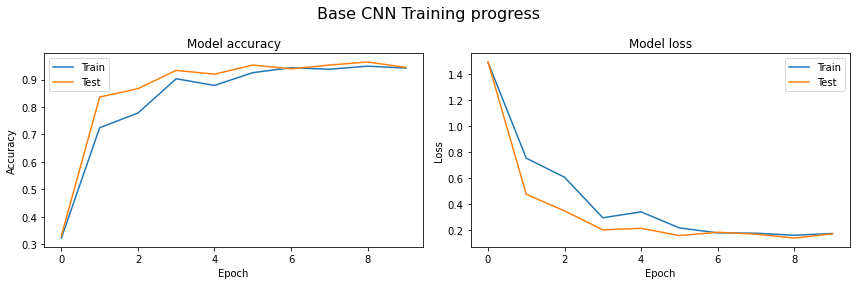

In [147]:
grapher(history_base_cnn, 'Base CNN Training progress')

#### Model is tuned quite well, no need to change hyperparameters

#### Classes Crazing, Pitted and Scratches don't have very good f1-scores

## 3.0 Hyperparameter tuning

In [400]:
# lr, dropout before last layer, SGD (grid search), reshuffle see if same, random seed, different (copy) notebook, still show even if tuning isworse

In [2]:
# learning_rate:(0,0001, 00)
# optimizers: (Adam,SGD)
# dropout rate: (0, 0.5)

def create_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_rate', 0, 0.2, step=0.1, default=0.0)))
    model.add(layers.Dense(6, activation='softmax'))

    optimizer = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate = hp.Float('learning_rate', 0.0001, 0.01, sampling='log', default=0.001)

    if optimizer == 'adam':
        model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy',\
                    metrics=['accuracy'])
    else:
        model.compile( optimizer=keras.optimizers.SGD(learning_rate),loss='categorical_crossentropy',\
            metrics=['accuracy'])

    return model

In [5]:
shutil.rmtree('my_tuner_directory', ignore_errors=True)

tuner = RandomSearch(create_model, objective='val_accuracy', max_trials=10, executions_per_trial=1, \
                     directory='my_tuner_directory', project_name='image_classification')

NameError: name 'RandomSearch' is not defined

In [ ]:
tuner.search_space_summary()

tuner.search(X_train, y_train, validation_split=0.2, epochs=10, batch_size=16)

best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

## 4.0 Tuning

### Standard Score Normalizing


In [291]:
mean = np.mean(X)
std = np.std(X)

X_adj = (X - mean)/std

In [296]:
X_train_adj, X_test_adj, y_train, y_test = train_test_split(X_adj, y, test_size=0.2)

In [301]:
norm_cnn = create_model()

In [302]:
norm_cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [303]:
callback = EarlyStopping()
history_norm_cnn = norm_cnn.fit(X_train_adj, y_train, epochs=15, validation_data=(X_test_adj, y_test),\
                                callbacks=[callback])

Epoch 1/15
45/45 [==============================] - 48s 1s/step - loss: 1.2592 - accuracy: 0.4785 - val_loss: 0.8253 - val_accuracy: 0.7250
Epoch 2/15
45/45 [==============================] - 51s 1s/step - loss: 0.5069 - accuracy: 0.8167 - val_loss: 0.4807 - val_accuracy: 0.8222
Epoch 3/15
45/45 [==============================] - 48s 1s/step - loss: 0.3743 - accuracy: 0.8618 - val_loss: 0.2978 - val_accuracy: 0.8722
Epoch 4/15
45/45 [==============================] - 46s 1s/step - loss: 0.1989 - accuracy: 0.9312 - val_loss: 0.2514 - val_accuracy: 0.9167
Epoch 5/15
45/45 [==============================] - 47s 1s/step - loss: 0.1507 - accuracy: 0.9521 - val_loss: 0.1604 - val_accuracy: 0.9528
Epoch 6/15
45/45 [==============================] - 49s 1s/step - loss: 0.1105 - accuracy: 0.9625 - val_loss: 0.2237 - val_accuracy: 0.9222
Epoch 7/15
45/45 [==============================] - 48s 1s/step - loss: 0.1090 - accuracy: 0.9667 - val_loss: 0.2943 - val_accuracy: 0.8833
Epoch 8/15
45/45 [==

### CNN Rotation - 15

In [339]:
cnn_15 = create_model()

In [340]:
datagen = ImageDataGenerator(rotation_range=5)

datagen.fit(X_train)
cnn_15.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history_cnn_15 = cnn_15.fit(datagen.flow(X_train, y_train), epochs=15,
                    validation_data=(X_test, y_test))

Epoch 1/15


2023-06-14 13:14:03.009635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/40 [==============================] - 46s 1s/step - loss: 1.7548 - accuracy: 0.2103 - val_loss: 1.5722 - val_accuracy: 0.2852
Epoch 2/15
40/40 [==============================] - 45s 1s/step - loss: 1.4192 - accuracy: 0.4262 - val_loss: 1.1135 - val_accuracy: 0.5037
Epoch 3/15
40/40 [==============================] - 45s 1s/step - loss: 0.8304 - accuracy: 0.7167 - val_loss: 0.7422 - val_accuracy: 0.7259
Epoch 4/15
40/40 [==============================] - 45s 1s/step - loss: 0.6297 - accuracy: 0.7714 - val_loss: 0.8211 - val_accuracy: 0.7074
Epoch 5/15
40/40 [==============================] - 44s 1s/step - loss: 0.4017 - accuracy: 0.8595 - val_loss: 0.7751 - val_accuracy: 0.7259
Epoch 6/15
40/40 [==============================] - 45s 1s/step - loss: 0.2754 - accuracy: 0.9087 - val_loss: 1.1547 - val_accuracy: 0.6000
Epoch 7/15
40/40 [==============================] - 45s 1s/step - loss: 0.2578 - accuracy: 0.9095 - val_loss: 0.2928 - val_accuracy: 0.8778
Epoch 8/15
40/40 [=============

KeyboardInterrupt: 

In [1]:
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(optimizer='adam', dropout_rate=0.0, learning_rate=0.001):
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.SGD(learning_rate=learning_rate)

    model = keras.Sequential()
    model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(200, 200, 1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

# Define a wrapper function that passes the parameters to create_model
def model_wrapper(optimizer, dropout_rate, learning_rate):
    return lambda: create_model(optimizer=optimizer, dropout_rate=dropout_rate, learning_rate=learning_rate)

param_grid = {
    'optimizer': ['sgd', 'adam'],
    'dropout_rate': [0, 0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.05, 0.1]
}

cv_model = KerasClassifier(build_fn=model_wrapper, verbose=0)

grid_cv = GridSearchCV(estimator=cv_model, param_grid=param_grid, cv=4)
grid_result = grid_cv.fit(X_train, y_train)  # Replace X_train and y_train with your training data

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


2023-06-16 14:39:24.890514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/mh/9l7f5q2x0bsc05929xvm2nnh0000gn/T/ipykernel_88375/1811008746.py:38: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cv_model = KerasClassifier(build_fn=model_wrapper, verbose=0)


NameError: name 'X_train' is not defined